## Semi-supervised Learning using Sklearn & Tensorflow (AutoEncoders)

**Techniques for perfrorming semi-supervised learning**

Semi-supervised learning is a type of machine learning that combines both labeled and unlabeled data to improve the learning accuracy. In the real-world, having plenty of unlabeled data and little label data is common, because labeling data reliably is time-consuming and expensive, so it's normal to have only a few human-labeled instances.

### Data
The dataset used is the fashion mnist dataset, mainly because of its high dimensionality and simplicity (no complex features). The dataset consists of 28 x 28 pixel images that will be flattened.

In [1]:
# importing packages
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import copy

# scikit learn
from sklearn.semi_supervised import LabelPropagation, LabelSpreading, SelfTrainingClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.ensemble import RandomForestClassifier

# tensorflow-keras
import tensorflow as tf
from tensorflow import keras

2024-08-30 22:04:20.461170: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-30 22:04:20.486805: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-30 22:04:20.492452: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-30 22:04:20.515098: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-30 22:04:21.775539: W tensorflow/compiler/tf2

In [2]:
# loading and normalizing the dataset
fashion_mnist = keras.datasets.fashion_mnist.load_data()
(X_train, y_train), (X_test, y_test) = fashion_mnist
X_train = X_train.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255

## 1. Sklearn

sklearn has three algorithms for tackling unsupervised learning tasks, the first two we will look at is...
#### a. Label Propagation & Label Spreading

The main idea behind `LabelPropagation` is that labels from labeled data are propagated to unlabeled data by constructing a graph where nodes represent data points, and edges represent similarities between them. Labels from known nodes are spread to neighboring unlabeled nodes based on similarity.

`LabelSpreading` is similar to `LabelPropagation`, however it incorporates a regularization term that smooths the labels, ensuring the that labels change smoothly and more conservatively across the graph.

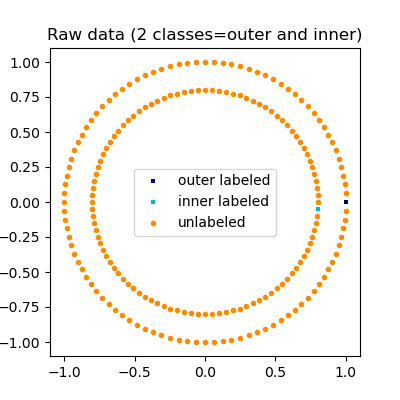


In [3]:
# helper function for preparing dataset
def create_unlabelled_targets(data, target, package, subset=1_000, size=60_000):
    if package == "sklearn":
        indices = np.random.choice(target.size, size=size, replace=False)
        y = copy.deepcopy(target).astype(np.int8) # mnist is immutable so we need to make a deep copy 
        X, y = data[indices], y[indices]
        y[:-subset] = -1        
        return X.reshape(-1, 784), y
    
    elif package == 'keras':
        X_train_labelled = data[-subset:]
        y_train_labelled = target[-subset:]
        return X_train_labelled, y_train_labelled
    
    else:
        raise ValueError("Unsupported package. Choose either 'sklearn' or 'keras'")

In [4]:
# helper function for model evaluation
def get_metrics(model, y_true=y_test, test_set=X_test, package="sklearn"):
    if package == "sklearn":
        y_pred = model.predict(test_set.reshape(-1, 784))  
    elif package == "keras":
        y_pred = np.argmax(model.predict(X_test), axis=1) 
    accuracy = accuracy_score(y_true, y_pred)
    f1score = f1_score(y_true, y_pred, average="weighted")
    report = classification_report(y_true, y_pred)
    print(f"""{model.__class__.__name__} metrics
--------------------------------------
1. accuracy score: {accuracy:.2%}
2. f1_score: {f1score: .2%}
3. classification report: \n{report}
          """)

In [5]:
# applying function 
sk_train, sk_target = create_unlabelled_targets(X_train, y_train, package="sklearn", size=20_000)

In [6]:
print("data shape:", sk_train.shape)

# verifying category count 
Counter(sk_target)

data shape: (20000, 784)


Counter({-1: 19000,
         6: 113,
         9: 110,
         7: 110,
         5: 101,
         0: 100,
         4: 100,
         3: 95,
         2: 95,
         8: 91,
         1: 85})

In this part we will only be working with 20_000 instances out of 60_000 because both `LabelPropagation` and `LabelSpreading` struggle with high-dimensional data as we will see. Dimensionality can be reduced using two techniques
1. csr matrix (if most of your data is sparse, i.e contains mostly 0's)
2. pca

both techniques had little impact on model performance, but helped sped up training. However, we will not be using any here

The data will consist of 1_000 labeled and 19_000 unlabeled instances. The labeled data will have correct targets, while the unlabeled data will assigned -1 as their target to distinguish them from labeled instances.

In [7]:
# instantiating both algorithms
 
label_prop_model = LabelPropagation()
label_spread_model = LabelSpreading()

models = [label_prop_model, label_spread_model]

In [8]:
for model in models:
    print(f"Training the {model.__class__.__name__} algorithm")
    model.fit(sk_train, sk_target)

Training the LabelPropagation algorithm
Training the LabelSpreading algorithm


In [9]:
# label propagation
get_metrics(label_prop_model)

LabelPropagation metrics
--------------------------------------
1. accuracy score: 12.93%
2. f1_score:  6.78%
3. classification report: 
              precision    recall  f1-score   support

           0       0.10      1.00      0.19      1000
           1       1.00      0.24      0.39      1000
           2       1.00      0.00      0.00      1000
           3       1.00      0.00      0.01      1000
           4       1.00      0.00      0.00      1000
           5       1.00      0.01      0.01      1000
           6       1.00      0.03      0.06      1000
           7       1.00      0.01      0.01      1000
           8       0.00      0.00      0.00      1000
           9       0.00      0.00      0.00      1000

    accuracy                           0.13     10000
   macro avg       0.71      0.13      0.07     10000
weighted avg       0.71      0.13      0.07     10000

          


In [10]:
# label spreading
get_metrics(label_spread_model)

LabelSpreading metrics
--------------------------------------
1. accuracy score: 12.93%
2. f1_score:  6.78%
3. classification report: 
              precision    recall  f1-score   support

           0       0.10      1.00      0.19      1000
           1       1.00      0.24      0.39      1000
           2       1.00      0.00      0.00      1000
           3       1.00      0.00      0.01      1000
           4       1.00      0.00      0.00      1000
           5       1.00      0.01      0.01      1000
           6       1.00      0.03      0.06      1000
           7       1.00      0.01      0.01      1000
           8       0.00      0.00      0.00      1000
           9       0.00      0.00      0.00      1000

    accuracy                           0.13     10000
   macro avg       0.71      0.13      0.07     10000
weighted avg       0.71      0.13      0.07     10000

          


`LabelPropagation` & `LabelSpreading` performed poorly mainly because of the curse of dimensionality. In high-dimensional data/spaces, the distances between points increases. Considering both algorithms make use of Euclidean distance to calculate similarity between points, the distance between points make this metric less meaningful, therefore it becomes harder to accurately capture the structure of the data which is essential for label propagation

### b. SelfTraining Classifier (RandomForestClassifier)

A self-training classifier is an iterative semi-supervised meta-estimator that takes an estimator as a parameter, trains the base estimator on a small set of labeled data to predict pseudo-labels that are added to the the labeled dataset, to re-train the algorithm until `max_iter` or no confident predictions can be made again.

`SelfTraining Classifiers` with RandomForest or SVC base estimators typically outperform `LabelPropagation` & `LabelSpreading` because they are less sensitive to the curse of dimensionality compared to algorithms that rely heavily on distance metrics.

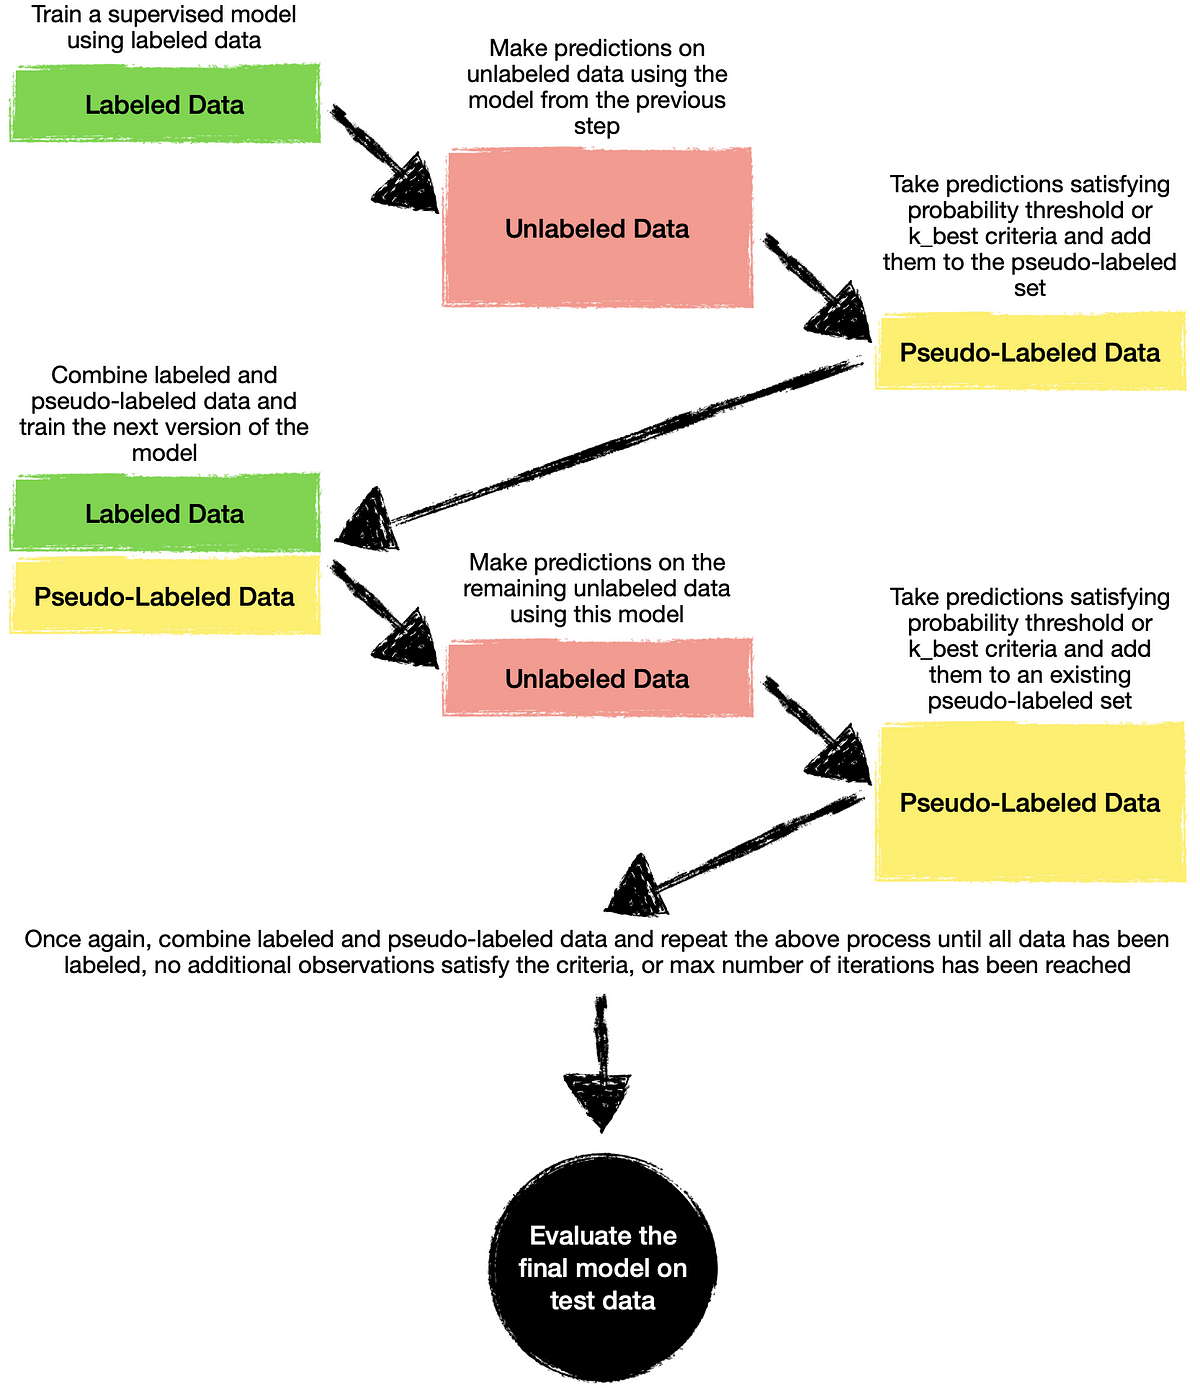

Considering that the curse of dimensionality will not be a problem with Self-Training classifiers, all 60_000 instances will be used.

In [11]:
# recreating dataset with 1_000 labeled instances and 59_000 unlabeled instances
sk_train, sk_target = create_unlabelled_targets(X_train, y_train, package="sklearn", size=60_000)

In [12]:
# verifying category count 
Counter(sk_target)

Counter({-1: 59000,
         7: 117,
         3: 110,
         5: 110,
         6: 108,
         8: 100,
         4: 97,
         9: 90,
         0: 90,
         2: 89,
         1: 89})

In [13]:
# instantiating the self-training classifier using random forest classifier as the base estimator
st_clf = SelfTrainingClassifier(base_estimator=RandomForestClassifier(random_state=42),
                             threshold=0.8, max_iter=10)

In [14]:
# fitting the self-training classifier
st_clf.fit(sk_train, sk_target)

SelfTrainingClassifier(base_estimator=RandomForestClassifier(random_state=42),
                       threshold=0.8)

In [15]:
get_metrics(st_clf)

SelfTrainingClassifier metrics
--------------------------------------
1. accuracy score: 76.73%
2. f1_score:  75.06%
3. classification report: 
              precision    recall  f1-score   support

           0       0.76      0.78      0.77      1000
           1       0.96      0.91      0.93      1000
           2       0.63      0.62      0.63      1000
           3       0.68      0.83      0.75      1000
           4       0.52      0.78      0.62      1000
           5       0.90      0.91      0.90      1000
           6       0.56      0.14      0.23      1000
           7       0.88      0.84      0.86      1000
           8       0.88      0.95      0.92      1000
           9       0.88      0.91      0.90      1000

    accuracy                           0.77     10000
   macro avg       0.77      0.77      0.75     10000
weighted avg       0.77      0.77      0.75     10000

          


The self-training classifier performs well as expected.

## 2. Tensorflow (AutoEncoders)

Autoencoders are artificial neural networks that are capable of learning dense representations (codings) of an input data without supervision, making them useful for a range of tasks such as dimensionality reduction, feature detection, and data generation. 

Autoencoders consists of two parts: an encoder for feature/pattern recognition, and a decoder for data reconstruction. The ability to learn latent representations of high dimensional data make them useful for various problems, including semi-supervised learning. The diagram below shows how a stacked autoencoder is used to perform unsupervised pretraining for a classification deep neural network, i.e semi-supervised learning.

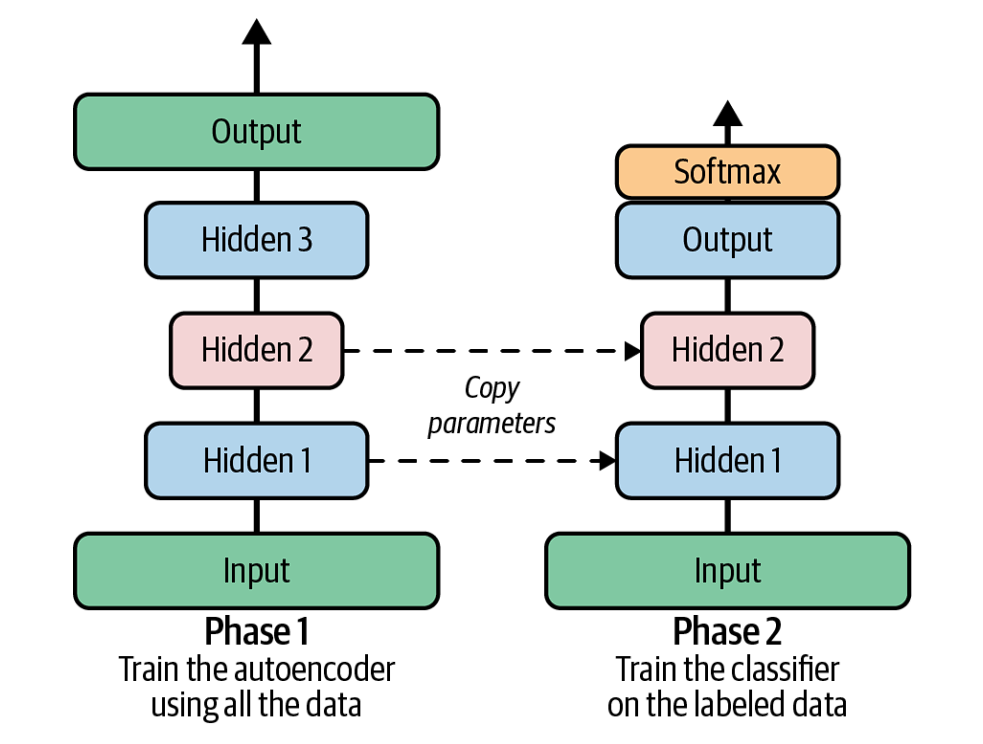

In [16]:
# creating keras labeled dataset containing 1_000 labeled instances
keras_train, keras_target = create_unlabelled_targets(X_train, y_train, package="keras")

In [17]:
keras_train.shape

(1000, 28, 28)

In [18]:
# Stacked autoencoder

keras.backend.clear_session()
tf.random.set_seed(42)

encoder = keras.Sequential([
    keras.layers.Input(shape=[28, 28]),
    keras.layers.Flatten(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(200, activation="relu"),
    keras.layers.Dense(100, activation="relu")
])

decoder = keras.Sequential([
    keras.layers.Dense(200, activation="relu"),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

autoencoder = keras.Sequential([encoder, decoder])

autoencoder.compile(loss="binary_crossentropy", optimizer="nadam", metrics=["mse"])

ae_EarlyStopping_cb = keras.callbacks.EarlyStopping(patience=10, monitor="val_mse", restore_best_weights=True)

history = autoencoder.fit(X_train, X_train, validation_split=0.2, epochs=100, callbacks=[ae_EarlyStopping_cb])

I0000 00:00:1725077525.757481  291418 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1725077525.846787  291418 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1725077525.846937  291418 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1725077525.848305  291418 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1725077525.848427  291418 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Epoch 1/100


I0000 00:00:1725077528.665865  294702 service.cc:146] XLA service 0x7f762c002360 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725077528.665925  294702 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2024-08-30 22:12:08.735325: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-30 22:12:08.857174: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


  79/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.5051 - mse: 0.0939

I0000 00:00:1725077530.572209  294702 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.3404 - mse: 0.0341 - val_loss: 0.2883 - val_mse: 0.0150
Epoch 2/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.2842 - mse: 0.0142 - val_loss: 0.2794 - val_mse: 0.0121
Epoch 3/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.2772 - mse: 0.0118 - val_loss: 0.2759 - val_mse: 0.0109
Epoch 4/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.2736 - mse: 0.0107 - val_loss: 0.2729 - val_mse: 0.0100
Epoch 5/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.2713 - mse: 0.0099 - val_loss: 0.2716 - val_mse: 0.0095
Epoch 6/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.2696 - mse: 0.0093 - val_loss: 0.2702 - val_mse: 0.0091
Epoch 7/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.2683 - mse: 0.0089 - val_loss: 0.2695 - val_mse: 0.0088
Epoch 8/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.2672 - mse: 0.0085 - val_loss: 0.2688 - val_mse: 0.0086
Epoch 9/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4

In [19]:
# freezing encoder weights
for layer in encoder.layers:
    layer.trainable = False

In [20]:
# Classification neural network using the trained encoder in the lower layer
keras.backend.clear_session()
tf.random.set_seed(44)

clf_dnn = keras.Sequential([
    encoder,
    keras.layers.Dense(150, activation="relu"),
    keras.layers.Dropout(0.25), # dropout layer to prevent overfitting
    keras.layers.Dense(50, activation="relu"),
    keras.layers.Dropout(0.3), # dropout layer to prevent overfitting
    keras.layers.Dense(10, activation="softmax")
])

clf_dnn.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

EarlyStopping_cb = keras.callbacks.EarlyStopping(patience=20, monitor="val_accuracy", restore_best_weights=True)

history_clf = clf_dnn.fit(keras_train, keras_target, validation_split=0.2, epochs=100, callbacks=[EarlyStopping_cb])

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.1351 - loss: 2.7288 - val_accuracy: 0.4100 - val_loss: 1.8989
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3494 - loss: 1.9282 - val_accuracy: 0.5900 - val_loss: 1.4385
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4373 - loss: 1.6068 - val_accuracy: 0.6750 - val_loss: 1.1420
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5279 - loss: 1.3917 - val_accuracy: 0.7200 - val_loss: 0.9567
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5951 - loss: 1.1509 - val_accuracy: 0.7400 - val_loss: 0.8308
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6151 - loss: 1.0806 - val_accuracy: 0.7400 - val_loss: 0.7958
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6626 - loss: 0.9705 - val_accuracy: 0.7550 - val_loss: 0.7647
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6660 - loss: 0.9366 - val_accuracy: 0.7650 - 

In [21]:
get_metrics(model=clf_dnn, package="keras")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Sequential metrics
--------------------------------------
1. accuracy score: 80.89%
2. f1_score:  80.53%
3. classification report: 
              precision    recall  f1-score   support

           0       0.63      0.87      0.73      1000
           1       0.96      0.94      0.95      1000
           2       0.66      0.70      0.68      1000
           3       0.86      0.78      0.82      1000
           4       0.72      0.70      0.71      1000
           5       0.94      0.88      0.91      1000
           6       0.65      0.42      0.51      1000
           7       0.88      0.93      0.90      1000
           8       0.90      0.94      0.92      1000
           9       0.92      0.93      0.93      1000

    accuracy                           0.81     10000
   macro avg       0.81      0.81      0.81     10000
weighted avg       0.81      0.81      0.81     10000

          


The classification neural network using the pretrained encoder had the best performance. The increase (~8%) in performance might not look impressive considering the complexity of neural networks, however, it's worth mentioning that Autoencoders really shine when fed complex data.

The advantage Autoencoders have over other semi-supervised learning techniques isn't visible here because the Fashion mnist dataset isn't complex enough. Autoencoders really shine when dealing with real-world data such as text, images, audio, time-series, and tabular data.